# Figure 5 & 6

**Figure 5.** Cross-sections of shortwave (a, b, c) and longwave (d, e, f) all-sky radiative heating for shallow cumulus clouds southwest of the cyclone center. The upper row shows 3D calculations, the middle row shows 1D calculations, and the lower row shows the differences between the 3D and 1D calculations. The cross sections are at hour 14 and -11.5 $^{\circ}$ longitude and between 37$^{\circ}$ and 38$^{\circ}$ north.

**Figure 6.** Average profiles of shortwave, longwave, and net 3D cloud radiative effects for the four cyclone regions. 3D cloud radiative effects are calculated as the difference in domain mean CRH between 3D (MYSTIC) and 1D (MYSTIC-ICA) radiative transfer calculations. The thin lines in panel (a) show the 3D radiative effects for nine snapshots between hours 10 to 14, with the legend indicating the time and domain mean solar zenith angles for all snapshots. Note the different x-axes in panels.

---
@ Behrooz Keshtgar, KIT 2023

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import colorlegend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as mcolors
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.23.5
matplotlib: 3.3.0


**Since datasets are large, I use DASK to speed up my analysis**

In [3]:
import dask
from dask.distributed import Client, progress, wait
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
client = Client()
client

<Client: 'tcp://127.0.0.1:42061' processes=9 threads=54, memory=53.69 GB>

## 2- Loading datasets

In [4]:
# Dictionary for loading datasets for the 4 simulations
simdict = {
         'LC1-LES-471x667km-lon25-lat40-300m-0006' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon40-lat44-300m-0003' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon30-lat53-300m-0005' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon50-lat48-300m-0004' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
          }

In [5]:
# all libradtrn simulation using ice parametrization of Fu
def load_simulations(num):
    ds_list = []
    sim = list(simdict.keys())[num]
    print('Working on loading data for', sim)
    path = '/work/bb1135/icon_output/'+sim+'/input4libradtran/libradtran/output_netcdf/'
    for solver in ['mysti','mcipa']:
        # loop over sources (thermal/solar)
        for source in ['thermal','solar']:
            # loop over sim types
            for nsim in ['01']: # simulations with Fu for ice param
                if solver in ['mysti','mcipa']:
                    ds = xr.open_mfdataset(path+'ds_librad_05T*_'+source+'_'+solver+'_'+nsim+'.nc',concat_dim='time',combine='nested',
                                           chunks={'height': 50},parallel=True).isel(height=slice(0,140))
                else:
                    ds = xr.open_mfdataset(path+'ds_librad2_05T*_'+source+'_'+solver+'_'+nsim+'.nc',concat_dim='time',combine='nested',
                                           chunks={'height': 50},parallel=True).isel(height=slice(0,140))
                ds.attrs['sim_name'] = 'ds_librad_'+source+'_'+solver+'_'+nsim+''
                ds_list.append(ds)
    return ds_list                
#-------------------------------------
ds_lib1=load_simulations(0)
ds_lib2=load_simulations(1)
ds_lib3=load_simulations(2)
ds_lib4=load_simulations(3)

## height values at full-levels
z_ifc = xr.open_dataset('/work/bb1135/icon_output/LC1-LES-471x667km-lon40-lat44-300m-0003/icon-atm3d_ML_20220105T120033Z.nc')["z_ifc"].isel(ncells=20000)
z_fl  = ((z_ifc - z_ifc.diff('height_3')/2).values)*1e-3 # km
# select between index 0:140
z_fl2  = z_fl[10:150][::-1]

Working on loading data for LC1-LES-471x667km-lon25-lat40-300m-0006
Working on loading data for LC1-LES-471x667km-lon40-lat44-300m-0003
Working on loading data for LC1-LES-471x667km-lon30-lat53-300m-0005
Working on loading data for LC1-LES-471x667km-lon50-lat48-300m-0004


## 3- Visuallaizing 3D cloud radiative effects

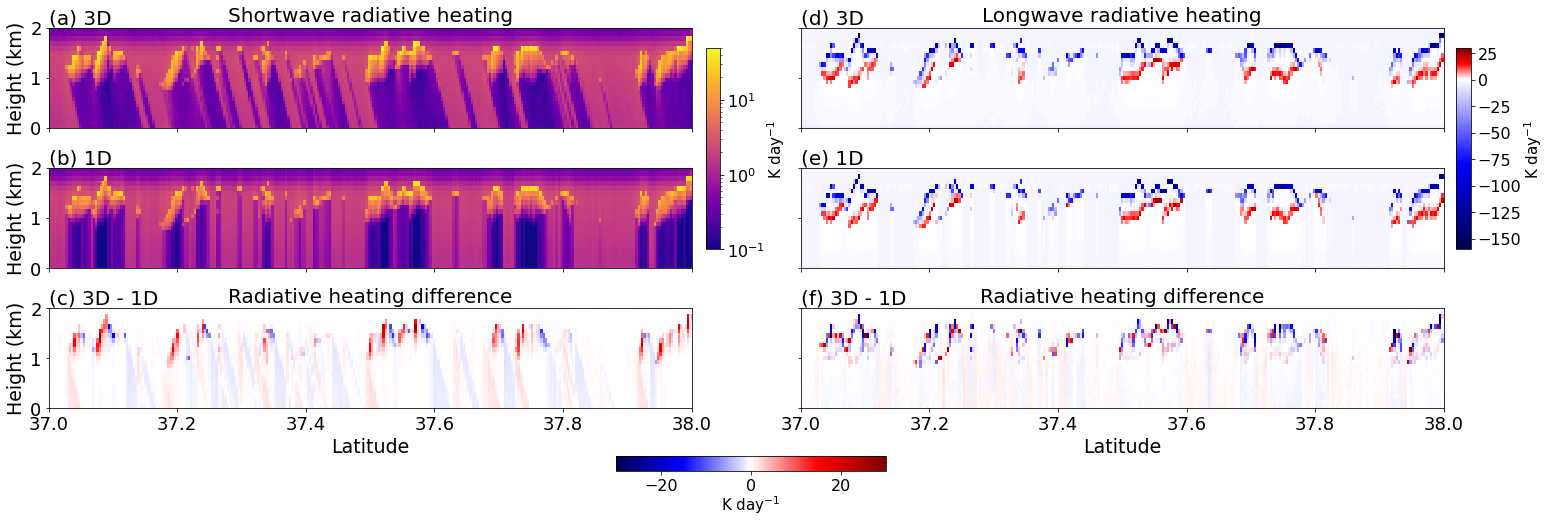

In [22]:
# adjusting colorbar
divnorm=mcolors.TwoSlopeNorm(vmin=-160., vcenter=1, vmax=30)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 7))

# coordinates for plotting
lat = np.linspace(37,43,1686)
lon = np.linspace(22,28,2064)
#lon[1550]-38

i = 0

for ax in axes.flat:
    ax.tick_params(labelsize=18)
    ax.set_xlim([37,38])
    ax.set_ylim([0,2])
    if i == 0:
        Z = ds_lib1[1].ddt_dom1.isel(time=8,lon=1550).transpose().values
        im1 = ax.pcolor(lat,z_fl2,Z,norm=mcolors.LogNorm(vmin=0.1, vmax=50),
                   cmap='plasma', shading='auto')
        ax.set_ylabel('Height (km)', fontsize=19)
        ax.set_title('Shortwave radiative heating', fontsize=20)
        #ax.set_xticklabels([])
        ax.set_xticklabels([])
        ax.text(0.0, 1.04, '(a) 3D', transform=ax.transAxes, 
            size=20)
       
    if i == 1:
        Z = ds_lib1[0].ddt_dom1.isel(time=8,lon=1550).transpose().values
        im2 = ax.pcolor(lat,z_fl2,Z,vmin=-160, vmax=30,cmap='seismic',norm=divnorm)
        ax.set_title('Longwave radiative heating', fontsize=20)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.text(0.0, 1.04, '(d) 3D', transform=ax.transAxes, 
            size=20)
        
    if i == 2:
        Z = ds_lib1[3].ddt_dom1.isel(time=8,lon=1550).transpose().values
        ax.pcolor(lat,z_fl2,Z,norm=mcolors.LogNorm(vmin=0.1, vmax=50),
                   cmap='plasma', shading='auto')
        #ax.set_title('LW RH', fontsize=16)
        ax.set_xticklabels([])
        ax.set_ylabel('Height (km)', fontsize=19)
        ax.text(0.0, 1.04, '(b) 1D', transform=ax.transAxes, 
            size=20)
        
    if i == 3:
        Z = ds_lib1[2].ddt_dom1.isel(time=8,lon=1550).transpose().values
        ax.pcolor(lat,z_fl2,Z,vmin=-160, vmax=30,cmap='seismic',norm=divnorm)
        #ax.set_title('LW RH', fontsize=16)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.text(0.0, 1.04, '(e) 1D', transform=ax.transAxes, 
            size=20)
        
    if i == 4:
        diff = (ds_lib1[1].ddt_dom1.isel(time=8,lon=1550)-ds_lib1[3].ddt_dom1.isel(time=8,lon=1550)).transpose().values
        im3 = ax.pcolor(lat,z_fl2,diff,
                  vmin=-30,vmax=30,cmap='seismic')
        ax.set_ylabel('Height (km)', fontsize=19)
        ax.set_title('Radiative heating difference', fontsize=20)
        ax.set_xlabel('Latitude', fontsize=19)
        #ax.set_xticklabels([])
        ax.text(0.0, 1.04, '(c) 3D - 1D', transform=ax.transAxes, 
            size=20)
        
    if i == 5:
        diff = (ds_lib1[0].ddt_dom1.isel(time=8,lon=1550)-ds_lib1[2].ddt_dom1.isel(time=8,lon=1550)).transpose().values
        ax.pcolor(lat,z_fl2,diff,
                  vmin=-30,vmax=30,cmap='seismic')
        ax.set_xlabel('Latitude', fontsize=19)
        ax.set_title('Radiative heating difference', fontsize=20)
        ax.set_yticklabels([])
        ax.text(0.0, 1.04, '(f) 3D - 1D', transform=ax.transAxes, 
            size=20)    
        
    i = i + 1
    
fig.subplots_adjust(wspace=0.17, hspace=0.4)

cb_ax = fig.add_axes([0.49, 0.44, 0.008, 0.4]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im1,cax=cb_ax,orientation='vertical',shrink=0.95)
cbar.set_label(label='K day$^{-1}$', size='15',labelpad=0.1)
cbar.ax.tick_params(labelsize=16)

cb_ax = fig.add_axes([0.907, 0.44, 0.008, 0.4]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im2,cax=cb_ax,orientation='vertical',shrink=0.95)
cbar.set_label(label='K day$^{-1}$', size='15',labelpad=1)
cbar.ax.tick_params(labelsize=16)

cb_ax = fig.add_axes([0.44, 0.0, 0.15, 0.03]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im3,cax=cb_ax,orientation='horizontal',shrink=0.95)
cbar.set_label(label='K day$^{-1}$', size='15',labelpad=1)
cbar.ax.tick_params(labelsize=16)

#plt.savefig('figure5.pdf', bbox_inches = 'tight')
plt.savefig('figure5.png', bbox_inches = 'tight',dpi=300)   

## 4- Average profiles of 3D cloud radiative effetcs

### 4.1 -Domain and time mean

In [9]:
# excluding boundaries and takin domain average for all snapshots
for i in range(4):
    ds_lib1[i]['ddt_radlw_smean'] = ds_lib1[i]['ddt_radlw'].isel(lon=slice(10,ds_lib1[i].lon.size-10),lat=slice(5,ds_lib1[i].lat.size-5)).mean(dim=['lat','lon']).compute()
    ds_lib2[i]['ddt_radlw_smean'] = ds_lib2[i]['ddt_radlw'].isel(lon=slice(10,ds_lib2[i].lon.size-10),lat=slice(5,ds_lib2[i].lat.size-5)).mean(dim=['lat','lon']).compute()
    ds_lib3[i]['ddt_radlw_smean'] = ds_lib3[i]['ddt_radlw'].isel(lon=slice(10,ds_lib3[i].lon.size-10),lat=slice(5,ds_lib3[i].lat.size-5)).mean(dim=['lat','lon']).compute()
    ds_lib4[i]['ddt_radlw_smean'] = ds_lib4[i]['ddt_radlw'].isel(lon=slice(10,ds_lib4[i].lon.size-10),lat=slice(5,ds_lib4[i].lat.size-5)).mean(dim=['lat','lon']).compute()
    
# time mean
for i in range(4):
    ds_lib1[i]['ddt_radlw_tmean'] = ds_lib1[i]['ddt_radlw_smean'].mean('time')
    ds_lib2[i]['ddt_radlw_tmean'] = ds_lib2[i]['ddt_radlw_smean'].mean('time')
    ds_lib3[i]['ddt_radlw_tmean'] = ds_lib3[i]['ddt_radlw_smean'].mean('time')
    ds_lib4[i]['ddt_radlw_tmean'] = ds_lib4[i]['ddt_radlw_smean'].mean('time')  

In [12]:
## domain mean solar zenith angles for legends:
T1000 = np.array(["37.92852833275016","37.80226949178842","37.69671682401419","37.61500059570729","37.55681047321208","37.52023226519184","38.915064020556464","38.791717045432485","38.69130644707883","38.6124667555098","38.55532033675725","38.52108367831912","39.89756930574191","39.78077150359704","39.683843308414886","39.60774709076623","39.55259379419657","39.51723294416274","40.88531971355025","40.77170908179705","40.67900799236836","40.60554511010893","40.55100744451595","40.518144268424","41.871281536401376","41.761552227572196","41.6697178725893","41.59878136419815","41.54843872264263","41.51671092273384","42.86007797171621","42.75409691648596","42.66536686448403","42.59687090328268","42.54830405297876","42.51766989988411"])
T1030 = np.array(["37.52804257737442","37.5708485262013","37.63525646429392","37.72313692501985","37.8348295917875","37.96714186785375","38.528617289510315","38.56887963670958","38.63201025502695","38.716806415256485","38.82312129316935","38.95233862619279","39.52450470667009","39.56568310493516","39.62660989841232","39.708454681810146","39.81108852936032","39.9335640002251","40.525161204083375","40.56362348781788","40.623754587836636","40.70276780222646","40.801001173719364","40.92008212134916","41.52348564954213","41.560619813285165","41.6163653520573","41.69266371028226","41.78984320404155","41.90485564921136","42.52421348857957","42.56006496745941","42.61384687101609","42.68752934071401","42.78142156329275","42.892511490806875"])
T1100 = np.array(["38.393382140661586","38.600978593063516","38.82890610307521","39.07773477712322","39.348481903382506","39.6369378833718","39.363927225231144","39.56395129822498","39.784699610121365","40.02524626154755","40.285220442690964","40.56617571466739","40.331149307066646","40.526690604926856","40.74007105812733","40.97265672879202","41.22411566204011","41.49379378885967","41.30414264361065","41.49143810158553","41.699415052597566","41.92430775667623","42.16714492937311","42.42841883599341","42.27593517464186","42.45696514886261","42.65580677226942","42.87331074609787","43.110431242317176","43.36325730818952","43.2510471213355","43.426024665409656","43.61821460873848","43.82854736490248","44.05795260030291","44.30257970328838"])
T1130 = np.array(["40.44165487593281","40.79517341482291","41.16627500474074","41.55440607164541","41.96130014675722","42.3820719537748","41.34524839499175","41.687713869889386","42.047414045180304","42.42379713129446","42.81641054514186","43.22699840313858","42.248183702305916","42.58211023033625","42.930771883486365","43.29576097771013","43.67665358752518","44.073184679411355","43.15879696979142","43.48031768182554","43.82026177828612","44.17414985378856","44.54367293360984","44.9283562661723","44.070430251562","44.38192973303821","44.70931291912708","45.052446552360756","45.41291230741974","45.786172037339895","44.98720091724115","45.288938133166084","45.60614178243116","45.93876085295428","46.2883428092579","46.65042970436143"])
T1200 = np.array(["43.50211594568874","43.97527181528498","44.46282048306486","44.96331269500535","45.47915438678598","46.005096395553494","44.3150466682018","44.77547815392289","45.249264736469335","45.73632122616192","46.23620735741138","46.75087221962785","45.130128921162566","45.579619773504504","46.04039981451561","46.514289111307946","47.00087692831748","47.50032350352602","45.95476018415644","46.389379144360724","46.83961452490772","47.30054956113451","47.77451281827034","48.26020496320508","46.782802646933796","47.20510812386976","47.640895397666284","48.089170949561236","48.552118961213885","49.024824418691146","47.61788468437165","48.0281029336541","48.451546100315205","48.887329737304704","49.337583804221204","49.797473922510704"])
T1230 = np.array(["47.37298481099091","47.93921762829051","48.51690408097273","49.1039174123586","49.70323218372862","50.30944323805887","48.08432474158632","48.637522367927055","49.20052156792213","49.77369095450026","50.35664786987366","50.95153566217326","48.799956197111236","49.34116735117","49.89048639142745","50.44995524366404","51.01921032206644","51.598821137349184","49.52631380121321","50.05158099135184","50.58971472382445","51.135574465877916","51.692030283912295","52.25711994962813","50.257933853848876","50.76986420180333","51.29288921767152","51.82532763166959","52.36989087901145","52.92146463286269","50.99796155460589","51.496677035303684","52.006364170309126","52.52544459678632","53.05656813151169","53.59469125116787"])
T1300 = np.array(["51.86525278681334","52.50163138171818","53.14708458600082","53.79892021300535","54.460587741235656","55.12664473307323","52.4729318119723","53.09676204632896","53.72743690884621","54.365731742394566","55.01135058606687","55.66655438303498","53.086105823806854","53.697745531359175","54.314860099119265","54.939646274813256","55.57180679440118","56.21228177556476","53.710287788163946","54.30582397615151","54.911834221627075","55.523085692916375","56.14288368017729","56.76873351633969","54.34076022365604","54.92277239554441","55.51380541502224","56.111594587658","56.71929353868736","57.331720241866364","54.98022277571468","55.54872124023649","56.1261978658082","56.71049383377817","57.30468131154461","57.9036473467872"])
T1330 = np.array(["56.82200151394028","57.51028685462972","58.20580702908052","58.905428907703616","59.612941706258766","60.32294837016508","57.32873029450165","58.00528311267857","58.686343393951205","59.37302749942263","60.06509818942504","60.76490058032287","57.84131104011324","58.505892757586004","59.17387410932022","59.847556632941895","60.5267054615","61.21256539012508","58.36435865451906","59.01316289095367","59.670471969779854","60.331039354919255","60.99853073445001","61.6699836082924","58.89394241575616","59.52948715602527","60.17235119183574","60.81979754299718","61.47531349684327","62.13373380049016","59.43232983181762","60.054530295128494","60.68405285944021","61.3182481911775","61.96053628082873","62.60580514800309"])
T1400 = np.array(["62.12047306956876","62.84662980092738","63.57863706129193","64.312980592758","65.05370823983753","65.79550053493416","62.53087253131712","63.246180395366196","63.96416740688413","64.68622745650455","65.41218301461255","66.1444058308444","62.94682454485622","63.650520562215156","64.35602268760988","65.06567569716411","65.77930370776433","66.49839779078314","63.372092113011014","64.06053517876158","64.75588599847472","65.45296073560695","66.15567487915047","66.86068908837552","63.80349610985502","64.47912423001112","65.16072632129466","65.84514350953924","66.53613331646902","67.22858765262404","64.24289592060603","64.9055655925753","65.57421869649646","66.24579206083693","66.92396218595137","67.60368642673636"])

print(T1000.astype(np.float).mean())
print(T1030.astype(np.float).mean())
print(T1100.astype(np.float).mean())
print(T1130.astype(np.float).mean())
print(T1200.astype(np.float).mean())
print(T1230.astype(np.float).mean())
print(T1300.astype(np.float).mean())
print(T1330.astype(np.float).mean())
print(T1400.astype(np.float).mean())

40.17127436330364
40.192631829642515
41.361084968865725
43.58149173338386
46.6986239725517
50.53935973704254
54.9427748575343
59.77328828519233
64.92210780393374


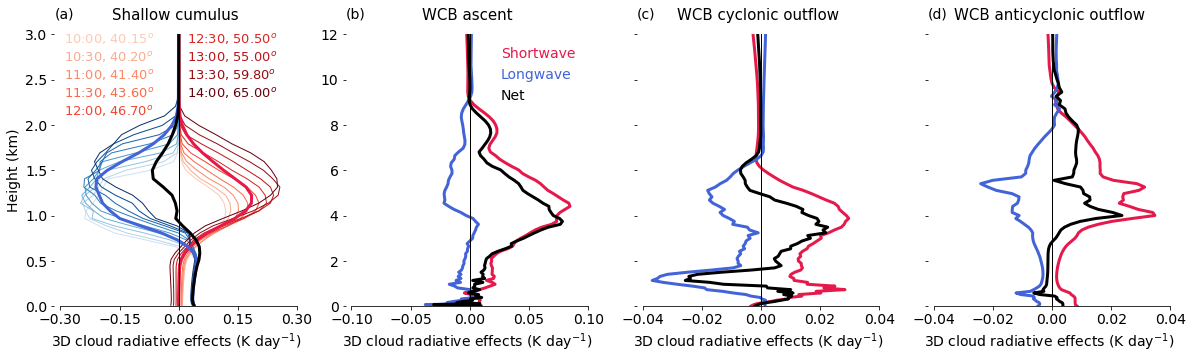

In [10]:
cmapr = cm.Reds(np.linspace(0.2,1,9))
cmapb = cm.Blues(np.linspace(0.2,1,9))
hour = ['10','10:30','11','11:30','12','12:30','13','13:30','14']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
i = 0

for ax in axes.flat:
    ax.tick_params(labelsize=14)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    
    if i == 0:
        
        for t in range(9):
            ax.plot(ds_lib1[0]['ddt_radlw_smean'][t].values-ds_lib1[2]['ddt_radlw_smean'][t].values,z_fl2,color=cmapb[t],lw=1
                    ,alpha=1)
            ax.plot(ds_lib1[1]['ddt_radlw_smean'][t].values-ds_lib1[3]['ddt_radlw_smean'][t].values,z_fl2,color=cmapr[t],lw=1
                    ,alpha=1,label='Hour: '+hour[t]+'')
        
        difflw = ds_lib1[0]['ddt_radlw_tmean'].values - ds_lib1[2]['ddt_radlw_tmean'].values
        diffsw = ds_lib1[1]['ddt_radlw_tmean'].values - ds_lib1[3]['ddt_radlw_tmean'].values
        total_diff = difflw + diffsw

        ax.set_title('Shallow cumulus', fontsize=15,pad=15)
        ax.plot(diffsw,z_fl2,color='#e6194B',lw=3)
        ax.plot(difflw,z_fl2,color='#4363d8',lw=3)
        ax.plot(total_diff,z_fl2,color='#000000',lw=3)
        #lg=colorlegend.color_legend(ax,loc=2,fsize=10)
        
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        ax.set_ylabel('Height (km)', fontsize=14)
        ax.set_xlabel('3D cloud radiative effects (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        ax.text(0.0, 1.06, '(a)', transform=ax.transAxes, 
            size=14)
        
        ax.set_ylim([0,3])
        
        ax.spines['bottom'].set_bounds(-0.3,0.3)
        ax.set_xticks(np.linspace(-0.3,0.3,5))
        ax.set_xlim([-0.315,0.3])
        
        ax.text(-0.29, 2.9, "10:00, 40.15$^o$", color=cmapr[0], size=13)
        ax.text(-0.29, 2.7, "10:30, 40.20$^o$", color=cmapr[1], size=13)
        ax.text(-0.29, 2.5, "11:00, 41.40$^o$", color=cmapr[2], size=13)
        ax.text(-0.29, 2.3, "11:30, 43.60$^o$", color=cmapr[3], size=13)
        ax.text(-0.29, 2.1, "12:00, 46.70$^o$", color=cmapr[4], size=13)
        
        ax.text(0.02, 2.9, "12:30, 50.50$^o$", color=cmapr[5], size=13)
        ax.text(0.02, 2.7, "13:00, 55.00$^o$", color=cmapr[6], size=13)
        ax.text(0.02, 2.5, "13:30, 59.80$^o$", color=cmapr[7], size=13)
        ax.text(0.02, 2.3, "14:00, 65.00$^o$", color=cmapr[8], size=13)
        
    if i == 1:
        
        #for t in range(9):
        #    ax.plot(ds_lib2[0]['ddt_radlw_smean'][t].values-ds_lib2[2]['ddt_radlw_smean'][t].values,z_fl2,color=cmapb[t],lw=0.5,alpha=0.5)
        #    ax.plot(ds_lib2[1]['ddt_radlw_smean'][t].values-ds_lib2[3]['ddt_radlw_smean'][t].values,z_fl2,color=cmapr[t],lw=0.5,alpha=0.5)
        
        difflw = ds_lib2[0]['ddt_radlw_tmean'].values - ds_lib2[2]['ddt_radlw_tmean'].values
        diffsw = ds_lib2[1]['ddt_radlw_tmean'].values - ds_lib2[3]['ddt_radlw_tmean'].values
        total_diff = difflw + diffsw

        ax.set_title('WCB ascent', fontsize=15,pad=15)
        ax.plot(diffsw,z_fl2,color='#e6194B',label='Shortwave',lw=3)
        ax.plot(difflw,z_fl2,color='#4363d8',label='Longwave',lw=3)
        ax.plot(total_diff,z_fl2,color='#000000',label='Net',lw=3)
        lg=colorlegend.color_legend(ax,loc=1,fsize=14)
        
        #ax.text(-0.09, 12, "Shortwave", color="#e6194B", size=14, ha="left", va="top")
        #ax.text(-0.09, 11.25, "Longwave", color='#4363d8', size=14, ha="left", va="top")
        #ax.text(-0.09, 10.5, "Total", color='gray', size=14, va="top")
        
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        #ax.set_ylabel('Height (km)', fontsize=14)
        ax.set_xlabel('3D cloud radiative effects (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        ax.text(0.0, 1.06, '(b)', transform=ax.transAxes, 
            size=14)
        
        ax.set_ylim([0,12])
        #ax.set_yticklabels([])
        
        ax.spines['bottom'].set_bounds(-0.1,0.1)
        ax.set_xticks(np.linspace(-0.1,0.1,5))
        ax.set_xlim([-0.105,0.1])
        
    if i == 2:
        difflw = ds_lib3[0]['ddt_radlw_tmean'].values - ds_lib3[2]['ddt_radlw_tmean'].values
        diffsw = ds_lib3[1]['ddt_radlw_tmean'].values - ds_lib3[3]['ddt_radlw_tmean'].values
        total_diff = difflw + diffsw

        ax.set_title('WCB cyclonic outflow', fontsize=15,pad=15)
        ax.plot(diffsw,z_fl2,color='#e6194B',label='Shortwave',lw=3)
        ax.plot(difflw,z_fl2,color='#4363d8',label='Longwave',lw=3)
        ax.plot(total_diff,z_fl2,color='#000000',label='Total',lw=3)
        #lg=colorlegend.color_legend(ax,loc=2,fsize=14)
        
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        #ax.set_ylabel('Height (km)', fontsize=14)
        ax.set_xlabel('3D cloud radiative effects (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        ax.text(0.0, 1.06, '(c)', transform=ax.transAxes, 
            size=14)
        
        ax.set_ylim([0,12])
        ax.set_yticklabels([])
        
        ax.spines['bottom'].set_bounds(-0.04,0.04)
        ax.set_xticks(np.linspace(-0.04,0.04,5))
        ax.set_xlim([-0.042,0.04])
    
    if i == 3:
        difflw = ds_lib4[0]['ddt_radlw_tmean'].values - ds_lib4[2]['ddt_radlw_tmean'].values
        diffsw = ds_lib4[1]['ddt_radlw_tmean'].values - ds_lib4[3]['ddt_radlw_tmean'].values
        total_diff = difflw + diffsw

        ax.set_title('WCB anticyclonic outflow', fontsize=15,pad=15)
        ax.plot(diffsw,z_fl2,color='#e6194B',label='Shortwave',lw=3)
        ax.plot(difflw,z_fl2,color='#4363d8',label='Longwave',lw=3)
        ax.plot(total_diff,z_fl2,color='#000000',label='Total',lw=3)
        #lg=colorlegend.color_legend(ax,loc=2,fsize=14)
        
        ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
        #ax.set_ylabel('Height (km)', fontsize=14)
        ax.set_xlabel('3D cloud radiative effects (K day$^{-1}$)', fontsize=14)#,labelpad=10)
        ax.text(0.0, 1.06, '(d)', transform=ax.transAxes, 
            size=14)
        
        ax.set_ylim([0,12])
        ax.set_yticklabels([])
        
        ax.spines['bottom'].set_bounds(-0.04,0.04)
        ax.set_xticks(np.linspace(-0.04,0.04,5))
        ax.set_xlim([-0.042,0.04])
        
    i = i + 1    

fig.subplots_adjust(wspace=0.2,hspace=0.35)     
plt.savefig('figure6.pdf', bbox_inches = 'tight')
plt.savefig('figure6.png', bbox_inches = 'tight',dpi=300)    

## 5- 3D cloud radiative effects at 2.5 km resolution

Text(0.5, 1.0, '3D-1D coarse_graind shortwave RH')

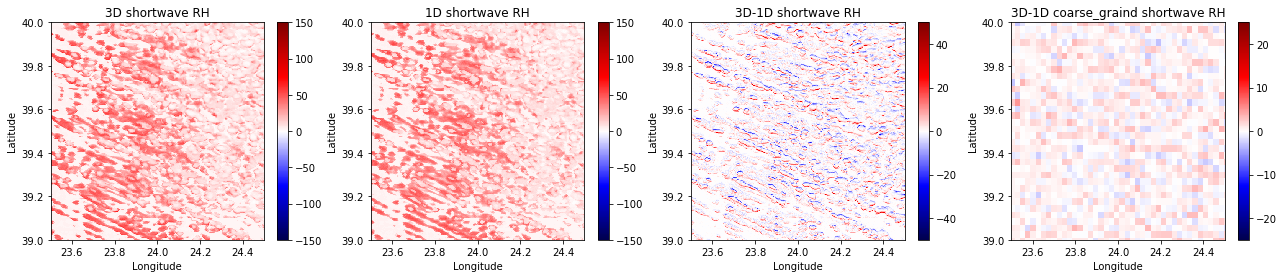

In [16]:
lat = np.linspace(37,43,1686)
lon = np.linspace(22,28,2064)

lat1 = np.linspace(37,43,198)
lon1 = np.linspace(22,28,246)

plt.figure(figsize=(22,4))

plt.subplot(141)
plt.pcolor(lon,lat,ds_lib1[1].ddt_dom1.isel(time=8,height=22).transpose(),cmap='seismic',vmin=-150,vmax=150)
plt.colorbar()
plt.xlim(23.5,24.5)
plt.ylim(39,40)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('3D shortwave RH')

plt.subplot(142)
plt.pcolor(lon,lat,ds_lib1[3].ddt_dom1.isel(time=8,height=22).transpose(),cmap='seismic',vmin=-150,vmax=150)
plt.colorbar()
plt.xlim(23.5,24.5)
plt.ylim(39,40)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('1D shortwave RH')

plt.subplot(143)
diff = ds_lib1[1].ddt_dom1.isel(time=8,height=22) - ds_lib1[3].ddt_dom1.isel(time=8,height=22)
plt.pcolor(lon,lat,diff.transpose(),cmap='seismic',vmin=-50,vmax=50)
plt.colorbar()
plt.xlim(23.5,24.5)
plt.ylim(39,40)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('3D-1D shortwave RH')

diff_cg = []
tm1 = np.array_split(diff.transpose('lon','lat').values,246,axis=0) #2.5 km grid spacing
arr1 = np.zeros((246,198))
#-----------------------------------------------
for i in range(len(tm1)):
    tmm_1 = np.array_split(tm1[i],198,axis=1)
    for j in range(len(tmm_1)):
        arr1[i,j] = tmm_1[j].mean() 
    #--------------------------------------------------
diff_cg=xr.DataArray(arr1,dims=["lon", "lat"])   

plt.subplot(144)
plt.pcolor(lon1,lat1,diff_cg.transpose(),cmap='seismic',vmin=-25,vmax=25)
plt.colorbar()
plt.xlim(23.5,24.5)
plt.ylim(39,40)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('3D-1D coarse_graind shortwave RH')

In [29]:
client.close()